<img src="https://pbs.twimg.com/profile_images/1523691369763684357/FPimkdzj_400x400.jpg" align="right" style="float" width="200">
<font color="#0096d2"><h1 align="left">Datamecum: Programa técnico intensivo en data science.</h1></font>
<font color="#00628a"><h2 align="left">Módulo No supervisado</h2></font>
<font color="#00628a"><h2 align="left">Anomalías con Regresión/Reconstrucción</h2></font>

# 1) Autoencoder

Generamos un autoencoder y detectamos anomalías en función de su error de reconstrucción. Utilizamos 5000 datos de una serie temporal de latidos del corazón (ECG), cada uno con 140 puntos.
Están etiquetados como 0 (correspondiente a un ritmo anormal) o 1 (correspondiente a un ritmo normal)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Leemos los datos
dataframe = pd.read_csv('/content/drive/MyDrive/Datamecum/PSD3/Anomalias/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.257740  0.228077  0.123431  0.925286  0.193137  1.0  
1  0.555784  0.476333  0.773820  1.119621 -1.436250  1.0  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797  1.0  
3  0.952074  0.990133  1.086798  1.403011 -0.383564  1.0  
4  1.277392  0.960304  0.971020  1.614392  1.421456  1.0  

[5 rows x 141 columns]

In [4]:
dataframe.shape

(4998, 141)

## Procesamiento de los datos

In [5]:
# la última columna contiene las etiquetas (0 = ritmo normal, 1 = ritmo anómalo)
labels = raw_data[:,-1]

# nuestros datos son el resto de puntos
data = raw_data[:,:-1]

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state = 21)

In [8]:
# normalizamos los datos entre [0,1]

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data-min_val)/(max_val-min_val)

min_val = tf.reduce_min(test_data)
max_val = tf.reduce_max(test_data)

test_data = (test_data-min_val)/(max_val-min_val)

In [13]:
# Entrenaremos el codificador automático usando solo los ritmos normales.

# Separar los ritmos normales de los ritmos anormales.

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# filtramos para ritmos normales

normal_train_data = train_data[train_labels] #train_data[train_labels==1]
normal_test_data = test_data[test_labels]

# los anómalos son los que tienen falso en cada uno (~ es el negado)

anomalous_train_data = train_data[~train_labels] #train_data[train_labels==0]
anomalous_test_data = test_data[~test_labels]

In [15]:
normal_train_data.shape

TensorShape([2359, 140])

In [16]:
anomalous_train_data.shape

TensorShape([1639, 140])

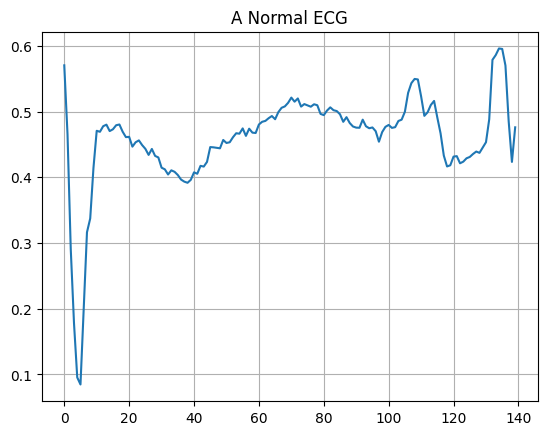

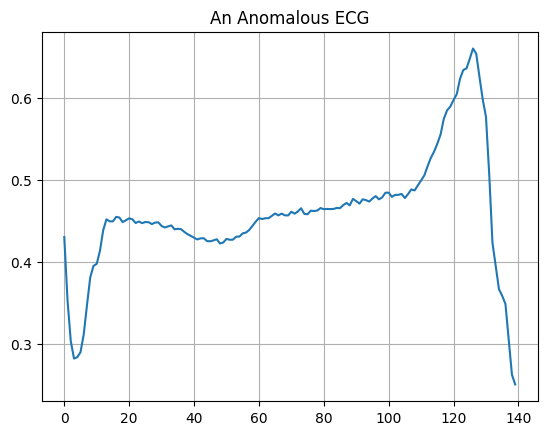

In [14]:
# pintamos un ECG normal y uno anómalo

plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

## Carga del modelo

In [17]:
# definición del modelo (ahora no es necesario entender el modelo!! Cuando veamos deep learning seremos capaces!)

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# nos quedamos con que tengo un modelo que predice cuando hago uso de él
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
# para que mi modelo aprenda, tenemos que entrenarlo con los datos normales sólo (estamos buscando anomalías!)

history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=50,
          batch_size=512,
          shuffle=True, verbose = 1)

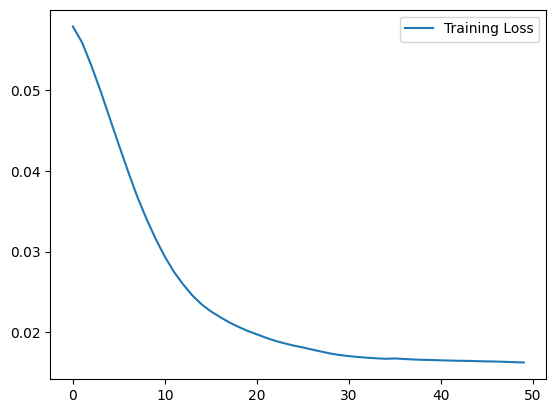

In [20]:
plt.plot(history.history["loss"], label="Training Loss")
#plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [21]:
# lo pasas a np para poder pintarlo, porque sino son tensores por dentro

# Pasamos por el modelo los ECG normales -> la predicción de mi modelo es decoded_data
encoded_data = autoencoder.encoder(normal_test_data).numpy() # codifica los datos
decoded_data = autoencoder.decoder(encoded_data).numpy() # decodifica los datos


## Detección de anomalías

Clasificará un ECG como anómalo si el error de reconstrucción es mayor que una desviación estándar de los ejemplos de entrenamiento normales. Primero, tracemos un ECG normal del conjunto de entrenamiento, la reconstrucción después de que el codificador automático lo codifique y decodifique, y el error de reconstrucción.

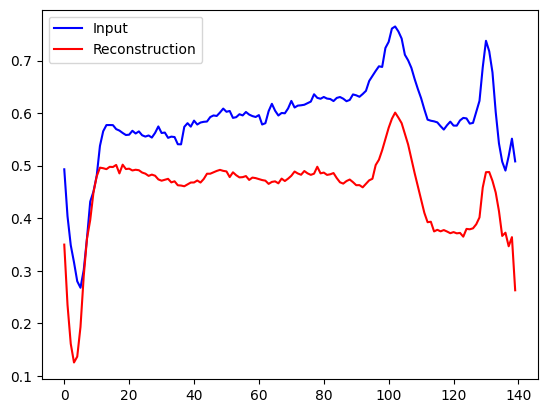

In [31]:
# dibujamos una ECG y el valor predicho por el modelo

# con normal_test_data

plt.plot(normal_test_data[15], 'b') # dato original
plt.plot(decoded_data[15], 'r') # salida del modelo
#plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [30]:
# probamos con uno anómalo

# LE PASAMOS LOS ANÓMALOS
encoded_data = autoencoder.encoder(anomalous_test_data).numpy() # codifica los datos
decoded_data = autoencoder.decoder(encoded_data).numpy() # decodifica los datos

# Lo pintamos

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Error de reconstrucción

In [33]:
# vemos cuanto vale la desviación entre la línea 'azul' (ECG real) y la predicción de mi algoritmo

np.sum(np.abs(decoded_data[0] - anomalous_test_data[0]))/140

0.13774892998478463

74/74 [==============================] - 0s 2ms/step


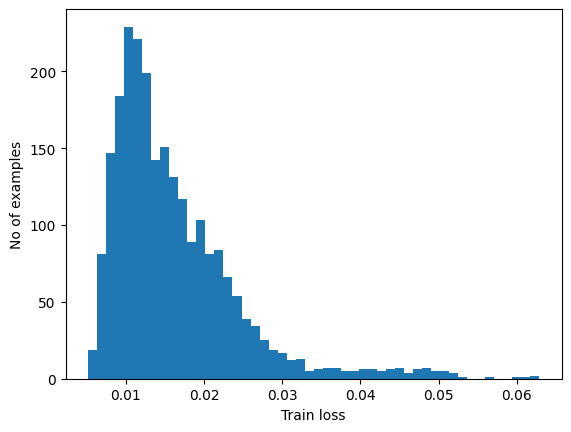

In [29]:
# error de reconstrucción
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

18/18 [==============================] - 0s 2ms/step


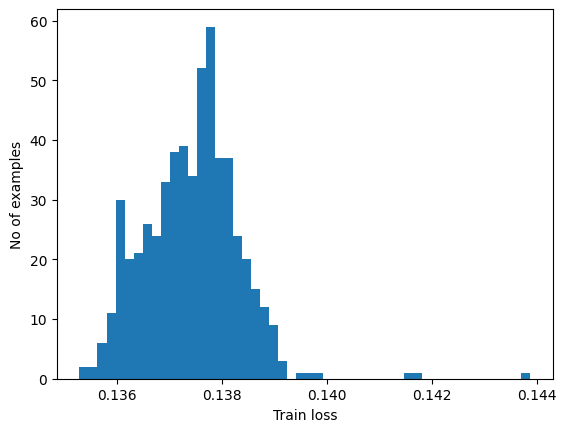

In [35]:
# error de reconstrucción
reconstructions = autoencoder.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

14/14 [==============================] - 0s 3ms/step


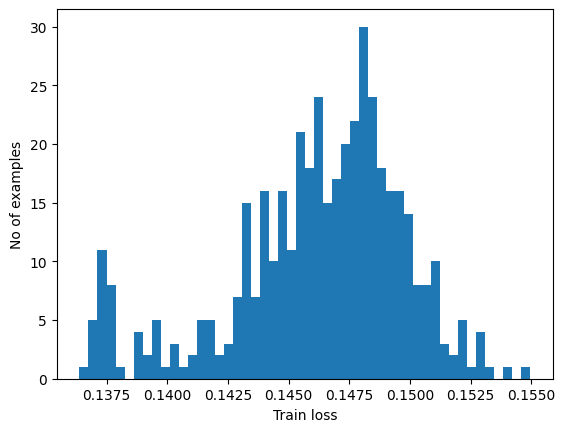

In [32]:
# error de reconstrucción
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

## EJERCICIO

Detectar anomalías calculando si el error de reconstrucción es mayor que un umbral fijo.


In [ ]:
threshold =

print("Threshold: ", threshold)

In [ ]:
# podríamos ver la distribución de errores de los anómalos
# estos son sólo los datos anómalos porque ya me los he separado antes

reconstructions =
test_loss =

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()